## [NYCDSA Capstone Project] 
# Women's Softball League Power Ranking Estimate

<br>
Koeun Lim (koeunlim@alum.mit.edu)<br>
Kevin Haghi (kevin.haghi@gmail.com)<br>


# Step 6-1. Modeling 2 - WS 64 Seed - XGBoost Classification

---
## Project Description



### Project Outline
- Step 1. Web scraping
- Step 2. Clean data
- Step 3. EDA
- Step 4. Imputation & PCA
- Step 5-1. Modeling (1) RPI prediction based on stats - XGboost regression
- Step 5-2. Modeling (1) RPI prediction based on stats - Linear regression
- Step 6-1. Modeling (2) WS 64 Seed prediction based on stats - XGboost classification
- Step 6-2. Modeling (2) WS 64 Seed prediction based on stats - Logistic regression

In [1]:
import pickle

import pandas as pd
import numpy as np
import seaborn as sn
from datetime import datetime
from scipy import stats
from matplotlib import pyplot as plt

import xgboost as xgb
from xgboost import plot_importance

import sklearn.model_selection as ms
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.utils import resample

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)
pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 250)

In [2]:
y_WSin = pd.read_csv('Data/y_WSin.csv')
y_WSin_2019 = pd.read_csv('Data/y_WSin_2019.csv')

X_famd = pd.read_csv('Data/X_famd.csv')
X_famd_2019 = pd.read_csv('Data/X_famd_2019.csv')
X_College = pd.read_csv('Data/X_College.csv')
X_College_2019 = pd.read_csv('Data/X_College_2019.csv')

In [3]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [4]:
# A parameter grid for XGBoost
params = {
    'min_child_weight': [1, 2, 5, 10],
    'gamma': [0, 1, 2, 5],
    'reg_alpha': [0],
    'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200, 300],
    'random_state' :[1]
}

xg_clf = xgb.XGBClassifier(objective ='binary:logistic',nthread= -1,gpu_id=-1,base_score = 384/1771,eval_metric = 'logloss')

In [5]:
folds = 5
param_comb = 100

random_search1 = RandomizedSearchCV(
    xg_clf, 
    param_distributions=params, 
    n_iter=param_comb, 
    scoring='accuracy',
    n_jobs=-1, 
    cv=folds, 
    verbose=3
)

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search1.fit(X_famd,y_WSin)
timer(start_time) # timing ends here for "start_time" variable

Fitting 5 folds for each of 100 candidates, totalling 500 fits

 Time taken: 0 hours 4 minutes and 58.26 seconds.


In [51]:
print('\n All results:')
print(random_search1.cv_results_)
print('\n\n Best estimator:')
print(random_search1.best_estimator_)
print('\n\n Best accuracy %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(-random_search1.best_score_)
print('\n\n Best accuracy %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(accuracy_score(y_WSin_2019, random_search1.predict(X_famd_2019)))
print('\n\n Best hyperparameters:')
print(random_search1.best_params_)
results1 = pd.DataFrame(random_search1.cv_results_).sort_values('rank_test_score', ascending=True)
results1.to_csv('XGBoost/xgb-random-grid-search-results-train_WS64_1.csv', index=False)


 All results:
{'mean_fit_time': array([2.05882359, 1.63563704, 1.06127667, 2.65618386, 2.45588536,
       4.17772574, 6.65075617, 2.73969336, 0.86027074, 4.18238034,
       4.14871359, 2.12339735, 4.00783496, 1.47321525, 2.80333276,
       3.3544147 , 3.11020679, 3.49057989, 1.42232862, 0.69819512,
       3.17031522, 3.3903841 , 3.78165302, 1.70111136, 1.15939102,
       2.079598  , 3.51238737, 2.24055872, 1.69795189, 0.81170568,
       2.27183809, 3.49519734, 2.77562575, 2.8347116 , 1.45178947,
       1.01058974, 2.72469668, 2.57340446, 2.8864717 , 5.7948905 ,
       2.38960786, 1.06301236, 2.17486062, 2.54477201, 2.48234944,
       1.648702  , 1.36962819, 2.67409577, 2.25504084, 4.2938251 ,
       3.04692421, 0.6975316 , 2.72676725, 1.81032476, 2.38578792,
       2.75123811, 1.59036326, 1.87483368, 3.43112597, 8.37203565,
       4.92519112, 2.19465227, 2.23168259, 1.48821149, 3.10344176,
       1.15416875, 1.93111219, 1.96159158, 1.70811982, 2.07352495,
       2.49800086, 3.74767556

In [52]:
print('\n\nBest Train Accuracy %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(accuracy_score(y_WSin, random_search1.predict(X_famd)))
print('\n')
print(confusion_matrix(y_WSin,random_search1.predict(X_famd)))


print('\n\nBest Test Accuracy %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(accuracy_score(y_WSin_2019, random_search1.predict(X_famd_2019)))
print('\n')
print(confusion_matrix(y_WSin_2019,random_search1.predict(X_famd_2019)))




Best Train Accuracy 5-fold search with 100 parameter combinations:
0.9294184076792772


[[1376   11]
 [ 114  270]]


Best Test Accuracy 5-fold search with 100 parameter combinations:
0.8720538720538721


[[223  10]
 [ 28  36]]


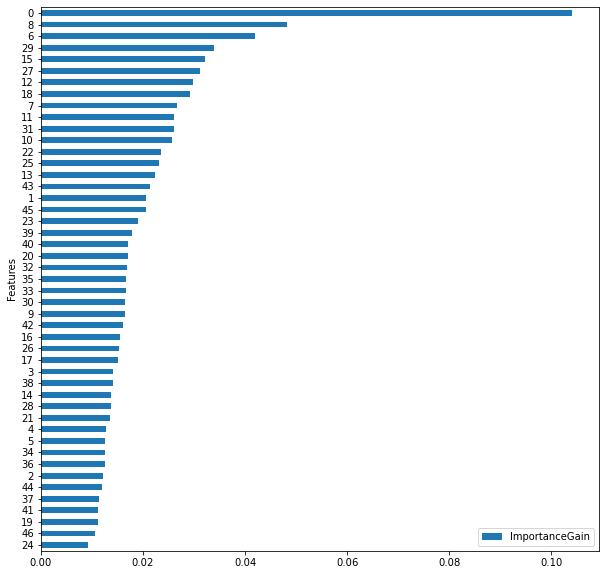

,Features,ImportanceGain,CummulativeGain
0,0,0.104126,0.104126
8,8,0.048223,0.152349
6,6,0.041949,0.194298
29,29,0.033893,0.228191
15,15,0.032147,0.260339
27,27,0.031178,0.291517
12,12,0.029784,0.321301
18,18,0.029221,0.350522
7,7,0.026701,0.377223
11,11,0.026159,0.403382


In [53]:
feature_importance1 = pd.DataFrame(X_famd.columns)
feature_importance1.columns = ['Features']
feature_importance1['ImportanceGain'] = random_search1.best_estimator_.feature_importances_
feature_importance1 = feature_importance1.sort_values('ImportanceGain', ascending=False)
feature_importance1['CummulativeGain'] = feature_importance1.ImportanceGain.cumsum()

plt.rcParams['figure.figsize'] = (10, 10)
feature_importance1 = feature_importance1.sort_values('ImportanceGain', ascending=False)
feature_importance1.sort_values('ImportanceGain', ascending=True).plot(x='Features',y='ImportanceGain',kind='barh')
plt.show()

feature_importance1

In [54]:
print(random_search1.best_estimator_)
print(random_search1.best_params_)

XGBClassifier(base_score=0.21682665160926032, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
              gamma=1, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.02, max_delta_step=0,
              max_depth=4, min_child_weight=5, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=4, nthread=-1,
              num_parallel_tree=1, random_state=1, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)
{'subsample': 0.8, 'reg_alpha': 0, 'random_state': 1, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.02, 'gamma': 1, 'colsample_bytree': 0.6}


In [55]:
best_xgbmodel = random_search1.best_estimator_
best_xgbmodel.fit(X_famd,y_WSin,sample_weight = None)
fname = 'WS64Seeds/xgbmodel_WSin.obj'
file = open(fname,'wb')
pickle.dump(best_xgbmodel,file)

[19:29:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [56]:
# boostrap resampling to generate prediction probability
n_bootstrap = 100
best_xgbmodel_i = random_search1.best_estimator_

y_ex = y_WSin_2019
X_ex = pd.DataFrame(X_famd_2019)
df_y_ex = pd.DataFrame()
df_prob_in = pd.DataFrame()
scores = []
for i_b in range(n_bootstrap):
    idx_resample =  resample(range(len(y_WSin)), replace=True, n_samples=len(y_WSin))
    X_i = X_famd.iloc[idx_resample]
    y_i = y_WSin.iloc[idx_resample]
    best_xgbmodel_i.fit(X_i,y_i,sample_weight = None)
    idx_test = y_WSin.index[~y_WSin.index.isin(y_i.index)]
    scores.append(best_xgbmodel_i.score(X_famd.loc[idx_test],y_WSin.loc[idx_test]))
    
    y_ex_est = pd.Series(best_xgbmodel_i.predict(X_ex))
    df_y_ex = df_y_ex.append(y_ex_est,ignore_index = True)
    prob_in_i = pd.DataFrame(best_xgbmodel_i.predict_proba(X_famd_2019)[:,1].reshape([1,-1])).round(decimals=2)
    df_prob_in = df_prob_in.append(prob_in_i,ignore_index = True)

df_y_ex.columns = X_College_2019.College
df_prob_in.columns = X_College_2019.College

[19:29:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:29:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:29:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:29:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607

[19:29:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:29:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:29:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:29:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607

[19:30:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:30:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:30:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:30:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607

[19:30:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:30:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:30:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:30:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607

In [57]:
df_prob_in.columns = X_College_2019.College
df_prob_in

College,Oklahoma,UCLA,Washington,Arizona,Florida State,Alabama,Minnesota,Texas,Oklahoma State,Florida,James Madison,Northwestern,LSU,Michigan,Ole Miss,Kentucky,Tennessee,ULL,Texas Tech,Auburn,North Carolina,Drake,South Carolina,Arizona State,Georgia,Missouri,Virginia Tech,Mississippi State,Wisconsin,Tulsa,Stanford,South Florida,Arkansas,Louisville,Boise State,Houston,Notre Dame,Colorado State,Ohio State,Lipscomb,Illinois,Oregon State,Southern Ill.,Louisiana Tech,UNLV,CSU Fullerton,North Dakota State,Iowa State,San Jose State,Texas A&M,UCF,Indiana,UT Arlington,North Texas,Liberty,Seattle U,WKU,Baylor,Southeast Mo. State,Oregon,Wichita State,Sam Houston State,Fresno State,Texas State,Troy,California,LMU (CA),UC Davis,Marshall,Longwood,Elon,New Mexico State,UNCG,Grand Canyon,Kent State,Coastal Carolina,DePaul,Jacksonville State,Miami (OH),Long Beach State,USC Upstate,Nicholls State,FGCU,NC State,McNeese State,Bradley,Missouri State,Duke,Rutgers,Georgia Tech,Eastern Ky.,Purdue,Hawaii,UNI,Nevada,Chattanooga,Boston U,Southern Miss.,San Diego State,Utah,Nebraska,Ohio,Austin Peay,North Florida,BYU,SFA,South Dakota State,Weber State,North Ala.,Appalachian State,Iowa,Stony Brook,State John's (NY),UMass Lowell,George Washington,Virginia,Toledo,Northern Ill.,FIU,LIU,Towson,Belmont,Maryland,Ball State,UIC,...,Ga. Southern,UTEP,Gardner-Webb,Creighton,Seton Hall,UT Martin,Lamar University,Pittsburgh,Houston Baptist,Western Mich.,Marist,ETSU,Tennessee Tech,UMBC,SIUE,Florida A&M,Colgate,Cal Poly,Columbia,Charlotte,Detroit Mercy,Jacksonville,Statetson,Central Ark.,Idaho State,Dayton,Furman,Bethune-Cookman,Binghamton,California Baptist,Bowling Green,Indiana State,Saint Louis,UMKC,La.-Monroe,Portland State,Charleston So.,Drexel,Army West Point,George Mason,Penn,Evansville,Valparaiso,Western Caro.,Prairie View,Texas Southern,Montana,Pacific,Fairfield,Utah Valley,Eastern Ill.,Butler,Georgetown,North Dakota,Tennessee State,Georgia State,Abilene Christian,Sacred Heart,Siena,Dartmouth,Youngstown State,Northern Colo.,Northern Ky.,Hampton,Saint Mary's (CA),UC Santa Barbara,Alabama State,Iona,San Diego,Santa Clara,Bryant,Mount State Mary's,Princeton,Manhattan,Norfolk State,Wright State,Hartford,A&M-Corpus Christi,IUPUI,Purdue Fort Wayne,Maine,Yale,Oakland,CSU Bakersfield,Canisius,Buffalo,Rhode Island,Akron,Robert Morris,Alabama A&M,UIW,Presbyterian,N.C. Central,Niagara,Central Conn. State,Wagner,Alcorn,Holy Cross,Cleveland State,Omaha,Morgan State,Green Bay,Mississippi Val.,Quinnipiac,Lafayette,Jackson State,Brown,Howard,Fairleigh Dickinson,La Salle,Morehead State,Cornell,N.C. A&T,Delaware State,Rider,Southern Utah,Coppin State,Savannah State,State Bonaventure,Grambling,Ark.-Pine Bluff,UMES,Southern U.,Saint Peter's,South Carolina State
0,0.85,0.90,0.95,0.95,0.89,0.94,0.92,0.91,0.78,0.96,0.74,0.89,0.96,0.91,0.94,0.93,0.95,0.79,0.81,0.90,0.67,0.72,0.91,0.63,0.91,0.86,0.87,0.77,0.86,0.25,0.29,0.26,0.90,0.40,0.33,0.60,0.79,0.58,0.78,0.28,0.35,0.13,0.36,0.44,0.57,0.18,0.61,0.27,0.28,0.35,0.22,0.50,0.11,0.14,0.34,0.48,0.50,0.04,0.46,0.12,0.56,0.08,0.36,0.07,0.36,0.44,0.23,0.46,0.49,0.10,0.08,0.29,0.19,0.35,0.12,0.37,0.26,0.36,0.30,0.20,0.86,0.24,0.11,0.07,0.05,0.14,0.04,0.05,0.18,0.10,0.14,0.10,0.11,0.22,0.17,0.17,0.40,0.47,0.12,0.05,0.08,0.18,0.33,0.09,0.23,0.24,0.18,0.07,0.04,0.09,0.04,0.52,0.14,0.13,0.17,0.03,0.10,0.14,0.04,0.25,0.10,0.10,0.03,0.18,0.49,...,0.06,0.02,0.09,0.05,0.06,0.10,0.03,0.09,0.03,0.03,0.15,0.06,0.04,0.40,0.03,0.13,0.05,0.03,0.13,0.01,0.09,0.03,0.06,0.07,0.06,0.05,0.03,0.29,0.04,0.25,0.03,0.03,0.02,0.07,0.03,0.05,0.05,0.20,0.06,0.03,0.19,0.04,0.03,0.04,0.25,0.16,0.04,0.04,0.04,0.04,0.07,0.02,0.03,0.03,0.03,0.04,0.02,0.07,0.08,0.04,0.11,0.06,0.04,0.04,0.09,0.05,0.12,0.03,0.03,0.04,0.04,0.15,0.08,0.03,0.10,0.05,0.05,0.02,0.03,0.04,0.03,0.05,0.03,0.10,0.03,0.02,0.04,0.03,0.03,0.14,0.04,0.08,0.15,0.05,0.06,0.03,0.07,0.04,0.04,0.03,0.05,0.04,0.08,0.05,0.06,0.06,0.06,0.05,0.07,0.03,0.03,0.04,0.05,0.06,0.04,0.05,0.04,0.16,0.02,0.05,0.03,0.04,

In [58]:
print(np.round(scores,decimals=3))
print(np.mean(scores))

[0.891 0.868 0.888 0.886 0.868 0.87  0.883 0.886 0.88  0.874 0.877 0.897
 0.889 0.891 0.887 0.889 0.895 0.878 0.89  0.887 0.905 0.89  0.888 0.886
 0.906 0.87  0.892 0.88  0.882 0.885 0.899 0.877 0.883 0.886 0.873 0.891
 0.889 0.902 0.895 0.895 0.882 0.891 0.885 0.876 0.908 0.874 0.914 0.889
 0.874 0.888 0.889 0.897 0.878 0.866 0.894 0.903 0.877 0.865 0.872 0.896
 0.883 0.891 0.879 0.859 0.893 0.884 0.871 0.888 0.881 0.877 0.9   0.893
 0.888 0.881 0.89  0.896 0.89  0.878 0.874 0.894 0.903 0.888 0.874 0.887
 0.9   0.896 0.891 0.91  0.887 0.889 0.887 0.875 0.875 0.887 0.885 0.869
 0.875 0.905 0.892 0.902]
0.8863025820213067


In [59]:
df_prob_in.to_csv('WS64Seeds/WS64_prediction_logistic.csv',index = False)
df_prob_in_5 = (df_prob_in*100/5).round(0)*5
df_prob_in

College,Oklahoma,UCLA,Washington,Arizona,Florida State,Alabama,Minnesota,Texas,Oklahoma State,Florida,James Madison,Northwestern,LSU,Michigan,Ole Miss,Kentucky,Tennessee,ULL,Texas Tech,Auburn,North Carolina,Drake,South Carolina,Arizona State,Georgia,Missouri,Virginia Tech,Mississippi State,Wisconsin,Tulsa,Stanford,South Florida,Arkansas,Louisville,Boise State,Houston,Notre Dame,Colorado State,Ohio State,Lipscomb,Illinois,Oregon State,Southern Ill.,Louisiana Tech,UNLV,CSU Fullerton,North Dakota State,Iowa State,San Jose State,Texas A&M,UCF,Indiana,UT Arlington,North Texas,Liberty,Seattle U,WKU,Baylor,Southeast Mo. State,Oregon,Wichita State,Sam Houston State,Fresno State,Texas State,Troy,California,LMU (CA),UC Davis,Marshall,Longwood,Elon,New Mexico State,UNCG,Grand Canyon,Kent State,Coastal Carolina,DePaul,Jacksonville State,Miami (OH),Long Beach State,USC Upstate,Nicholls State,FGCU,NC State,McNeese State,Bradley,Missouri State,Duke,Rutgers,Georgia Tech,Eastern Ky.,Purdue,Hawaii,UNI,Nevada,Chattanooga,Boston U,Southern Miss.,San Diego State,Utah,Nebraska,Ohio,Austin Peay,North Florida,BYU,SFA,South Dakota State,Weber State,North Ala.,Appalachian State,Iowa,Stony Brook,State John's (NY),UMass Lowell,George Washington,Virginia,Toledo,Northern Ill.,FIU,LIU,Towson,Belmont,Maryland,Ball State,UIC,...,Ga. Southern,UTEP,Gardner-Webb,Creighton,Seton Hall,UT Martin,Lamar University,Pittsburgh,Houston Baptist,Western Mich.,Marist,ETSU,Tennessee Tech,UMBC,SIUE,Florida A&M,Colgate,Cal Poly,Columbia,Charlotte,Detroit Mercy,Jacksonville,Statetson,Central Ark.,Idaho State,Dayton,Furman,Bethune-Cookman,Binghamton,California Baptist,Bowling Green,Indiana State,Saint Louis,UMKC,La.-Monroe,Portland State,Charleston So.,Drexel,Army West Point,George Mason,Penn,Evansville,Valparaiso,Western Caro.,Prairie View,Texas Southern,Montana,Pacific,Fairfield,Utah Valley,Eastern Ill.,Butler,Georgetown,North Dakota,Tennessee State,Georgia State,Abilene Christian,Sacred Heart,Siena,Dartmouth,Youngstown State,Northern Colo.,Northern Ky.,Hampton,Saint Mary's (CA),UC Santa Barbara,Alabama State,Iona,San Diego,Santa Clara,Bryant,Mount State Mary's,Princeton,Manhattan,Norfolk State,Wright State,Hartford,A&M-Corpus Christi,IUPUI,Purdue Fort Wayne,Maine,Yale,Oakland,CSU Bakersfield,Canisius,Buffalo,Rhode Island,Akron,Robert Morris,Alabama A&M,UIW,Presbyterian,N.C. Central,Niagara,Central Conn. State,Wagner,Alcorn,Holy Cross,Cleveland State,Omaha,Morgan State,Green Bay,Mississippi Val.,Quinnipiac,Lafayette,Jackson State,Brown,Howard,Fairleigh Dickinson,La Salle,Morehead State,Cornell,N.C. A&T,Delaware State,Rider,Southern Utah,Coppin State,Savannah State,State Bonaventure,Grambling,Ark.-Pine Bluff,UMES,Southern U.,Saint Peter's,South Carolina State
0,0.85,0.90,0.95,0.95,0.89,0.94,0.92,0.91,0.78,0.96,0.74,0.89,0.96,0.91,0.94,0.93,0.95,0.79,0.81,0.90,0.67,0.72,0.91,0.63,0.91,0.86,0.87,0.77,0.86,0.25,0.29,0.26,0.90,0.40,0.33,0.60,0.79,0.58,0.78,0.28,0.35,0.13,0.36,0.44,0.57,0.18,0.61,0.27,0.28,0.35,0.22,0.50,0.11,0.14,0.34,0.48,0.50,0.04,0.46,0.12,0.56,0.08,0.36,0.07,0.36,0.44,0.23,0.46,0.49,0.10,0.08,0.29,0.19,0.35,0.12,0.37,0.26,0.36,0.30,0.20,0.86,0.24,0.11,0.07,0.05,0.14,0.04,0.05,0.18,0.10,0.14,0.10,0.11,0.22,0.17,0.17,0.40,0.47,0.12,0.05,0.08,0.18,0.33,0.09,0.23,0.24,0.18,0.07,0.04,0.09,0.04,0.52,0.14,0.13,0.17,0.03,0.10,0.14,0.04,0.25,0.10,0.10,0.03,0.18,0.49,...,0.06,0.02,0.09,0.05,0.06,0.10,0.03,0.09,0.03,0.03,0.15,0.06,0.04,0.40,0.03,0.13,0.05,0.03,0.13,0.01,0.09,0.03,0.06,0.07,0.06,0.05,0.03,0.29,0.04,0.25,0.03,0.03,0.02,0.07,0.03,0.05,0.05,0.20,0.06,0.03,0.19,0.04,0.03,0.04,0.25,0.16,0.04,0.04,0.04,0.04,0.07,0.02,0.03,0.03,0.03,0.04,0.02,0.07,0.08,0.04,0.11,0.06,0.04,0.04,0.09,0.05,0.12,0.03,0.03,0.04,0.04,0.15,0.08,0.03,0.10,0.05,0.05,0.02,0.03,0.04,0.03,0.05,0.03,0.10,0.03,0.02,0.04,0.03,0.03,0.14,0.04,0.08,0.15,0.05,0.06,0.03,0.07,0.04,0.04,0.03,0.05,0.04,0.08,0.05,0.06,0.06,0.06,0.05,0.07,0.03,0.03,0.04,0.05,0.06,0.04,0.05,0.04,0.16,0.02,0.05,0.03,0.04,

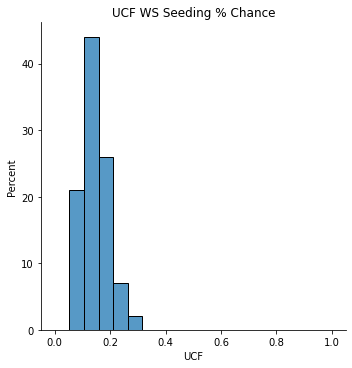

Actual result:  0
Predicted result (% peak chance making into WS):  10.0


In [60]:
idx_ex = 50
college = df_prob_in.columns[idx_ex]
bins = np.linspace(0,1,20)
sn.displot(data=df_prob_in,x=college,kde=False,bins=bins) 
plt.title(college + ' WS Seeding % Chance')
plt.ylabel('Percent')
plt.show()
print('Actual result: ', y_WSin_2019.WCWS_in.loc[idx_ex])
print('Predicted result (% peak chance making into WS): ',df_prob_in_5[college].value_counts().idxmax())

,College
0,Oklahoma
1,UCLA
2,Washington
3,Arizona
4,Florida State
...,...
292,Ark.-Pine Bluff
293,UMES
294,Southern U.
295,Saint Peter's
